In [1]:
# Cell 1: Install Dependencies
!pip install segmentation_models_pytorch wandb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [2]:
# Cell 2: Imports & SOTA Configuration
# ==================================================================================
import os
import cv2
import gc
import sys
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as distance

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

# Vision Libraries
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Logging
import wandb
from kaggle_secrets import UserSecretsClient

# --- SOTA CONFIGURATION ---
CONFIG = {
    "SEED": 42,
    "IMG_SIZE": 352,            # Upgraded from 320 -> 352 (Better stride compatibility)
    "MODEL_NAME": "UnetPlusPlus",
    "ENCODER": "resnext50_32x4d",
    "ENCODER_WEIGHTS": "imagenet",
    
    # Architecture Upgrades
    "DEEP_SUPERVISION": False,   # Gradient injection at all depths
    "DECODER_ATTENTION": None,# Spatial/Channel Squeeze & Excitation
    
    # Training Strategy
    "BATCH_SIZE": 16,           # Lowered slightly for 352 resolution
    "ACCUMULATE_GRAD": 2,       # Effective batch size = 32
    "EPOCHS": 100,              # Extended training for boundary refinement
    "LR": 2e-4,
    "WEIGHT_DECAY": 1e-5,
    
    # Dataset Paths (UPDATE THESE IF NEEDED)
    "GOLD_PATH": "/kaggle/input/gold-standard-new/200_AD_CN_MCI_11112025/",
    # Point this to the output of the generation script I gave you previously
    "PSEUDO_PATH": "/kaggle/input/uranium-standard-dataset/URANIUM_dataset_REAL_NEW_PATIENTS/", 
    
    # Split Strategy (To avoid timeout)
    "FOLDS_TO_RUN": [0, 1],  # <--- CHANGE TO [2, 3] FOR SECOND RUN
    "N_FOLDS": 5,
    
    # WandB
    "PROJECT_NAME": "Brain_SOTA_URANIUM_NEW_PATIENTS_Run",
    "ENTITY": "alzhemer_segmentaion"
}

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Configuration Loaded. Training on {DEVICE}. Target Resolution: {CONFIG['IMG_SIZE']}x{CONFIG['IMG_SIZE']}")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Configuration Loaded. Training on cuda. Target Resolution: 352x352


In [3]:
# Cell 3: Utils & Reproducibility
# ==================================================================================
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CONFIG['SEED'])

# Login to WandB
try:
    user_secrets = UserSecretsClient()
    wandb_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=wandb_key)
    print("✅ WandB Logged In")
except:
    print("⚠️ WandB Login Failed (Anonymous mode enabled)")
    wandb.login(anonymous='must')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yashsharmaat2004 (alzhemer_segmentaion) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ WandB Logged In


In [4]:
# Cell 4: Advanced Dataset Class (Fixed for Shape Mismatch)
# ==================================================================================
class BrainDataset(Dataset):
    def __init__(self, df, transform=None, phase="train"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Construct Paths
        if row['source'] == 'gold':
            img_path = os.path.join(CONFIG['GOLD_PATH'], 'images', row['image_id'])
            mask_path = os.path.join(CONFIG['GOLD_PATH'], 'masks', row['mask_id'])
        else:
            # Pseudo labels
            img_path = os.path.join(CONFIG['PSEUDO_PATH'], 'images', row['image_id'])
            mask_path = os.path.join(CONFIG['PSEUDO_PATH'], 'masks', row['mask_id'])
            
        # Read Image (Grayscale)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Convert to RGB for ImageNet Weights
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Read Mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # --- CRITICAL FIX: Shape Sanity Check ---
        # If mask dim doesn't match image dim, resize mask to match image
        if image.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        # ----------------------------------------
        
        # Binarize mask
        mask = np.where(mask > 127, 1.0, 0.0).astype(np.float32)
        
        if self.transform:
            # We pass check_shapes=False to be safe, though the resize above fixes it
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        # Ensure Channel Dimension for Mask
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)
            
        return image, mask

In [5]:
# Cell 5: SOTA Augmentations (ImageNet Stats)
# ==================================================================================
# ImageNet Statistics (Critical for Pre-trained Encoders)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def get_transforms(phase):
    if phase == 'train':
        return A.Compose([
            A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
            
            # SOTA: Heavy Geometric Augmentations (Student needs noise)
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.OneOf([
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
                A.GridDistortion(p=0.5),
                A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
            ], p=0.3),
            
            # SOTA: Intensity Augmentations
            A.OneOf([
                A.GaussNoise(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.RandomGamma(p=0.5),
            ], p=0.3),
            
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3), # Cutout
            
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])

In [6]:
# Cell 6: Dynamic Weighted Loss Function
# ==================================================================================
class HausdorffDTLoss(nn.Module):
    """Binary Hausdorff Loss based on distance transform"""
    def __init__(self, alpha=2.0):
        super(HausdorffDTLoss, self).__init__()
        self.alpha = alpha

    @torch.no_grad()
    def distance_field(self, img):
        field = np.zeros_like(img)
        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5
            if fg_mask.any():
                bg_mask = ~fg_mask
                fg_dist = distance(fg_mask)
                bg_dist = distance(bg_mask)
                field[batch] = fg_dist + bg_dist
        return field

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred_np = pred.detach().cpu().numpy()
        target_np = target.detach().cpu().numpy() # Target is already binary 0/1
        
        target_dist = torch.from_numpy(self.distance_field(target_np)).float().to(pred.device)
        pred_dist = torch.from_numpy(self.distance_field(pred_np)).float().to(pred.device)
        
        term_1 = (pred - target) ** 2 * target_dist
        term_2 = (target - pred) ** 2 * pred_dist
        
        return (term_1 + term_2).mean()

class SotaDynamicLoss(nn.Module):
    """
    Dynamic Scheduling:
    - Early Epochs: Focus on Dice/BCE (Volume coverage)
    - Late Epochs: Introduce Hausdorff (Boundary precision)
    """
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode='binary')
        self.hausdorff = HausdorffDTLoss()
        
    def forward(self, preds, targets, epoch):
        # Deep Supervision handling: preds might be a list
        if isinstance(preds, list):
            loss = 0
            # Weights for deep supervision heads (Decaying)
            weights = [1.0, 0.5, 0.25, 0.125] 
            for i, pred in enumerate(preds):
                if i < len(weights):
                    loss += weights[i] * self.calculate_single_loss(pred, targets, epoch)
            return loss
        else:
            return self.calculate_single_loss(preds, targets, epoch)
            
    def calculate_single_loss(self, pred, target, epoch):
        # 1. Volume Loss (Standard)
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        vol_loss = 0.5 * bce_loss + 0.5 * dice_loss
        
        # 2. Boundary Loss (Dynamic)
        if epoch < 20:
            return vol_loss
        else:
            # Gradually ramp up boundary loss
            boundary_weight = min(0.3, (epoch - 20) * 0.01) 
            hd_loss = self.hausdorff(pred, target)
            return (1 - boundary_weight) * vol_loss + boundary_weight * hd_loss

In [7]:
# Cell 7: Post-Processing (LCC) & Metrics [COMPLETE & FIXED]
# ==================================================================================

def keep_largest_component(mask):
    """
    SOTA Update: Keeps large components (Brain Hemispheres) but removes small noise.
    Preserves disconnected hemispheres if they are significant (>20% of max blob).
    """
    mask = mask.astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
    if num_labels < 2: return mask
    
    # stats[:, 4] is area. Index 0 is background.
    areas = stats[1:, 4]
    
    # If we have no components, return empty
    if len(areas) == 0:
        return mask
    
    # Find the largest area
    max_area = np.max(areas)
    
    # KEEP logic: Keep any component that is at least 20% of the largest component
    min_size_threshold = max_area * 0.20
    
    cleaned = np.zeros_like(mask)
    
    for i in range(1, num_labels):
        if stats[i, 4] >= min_size_threshold:
            cleaned[labels == i] = 1
            
    return cleaned

def compute_dice_with_lcc(y_pred_logits, y_true):
    """
    Computes Dice Score after applying SOTA LCC Cleaning.
    """
    # Apply Sigmoid to get probabilities
    probs = torch.sigmoid(y_pred_logits)
    preds = (probs > 0.5).cpu().numpy()
    y_true = y_true.cpu().numpy()
    
    batch_dice = []
    for i in range(len(preds)):
        # SOTA STEP: Clean prediction with LCC
        clean_pred = keep_largest_component(preds[i][0])
        target = y_true[i][0]
        
        intersection = (clean_pred * target).sum()
        union = clean_pred.sum() + target.sum()
        
        if union == 0:
            score = 1.0
        else:
            score = (2. * intersection) / (union + 1e-6)
        batch_dice.append(score)
        
    return np.mean(batch_dice)

In [8]:
# Cell 8: Model & Training Engine
# ==================================================================================
def build_model():
    model = smp.UnetPlusPlus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=CONFIG['ENCODER_WEIGHTS'],
        in_channels=3,                 # RGB Input
        classes=1,
        activation=None,               # Logits for loss stability
        deep_supervision=CONFIG['DEEP_SUPERVISION'], # SOTA Feature
        decoder_attention_type=CONFIG['DECODER_ATTENTION'] # SOTA Feature
    )
    return model.to(DEVICE)

def train_one_epoch(model, loader, optimizer, scheduler, loss_fn, scaler, epoch):
    model.train()
    running_loss = 0
    
    pbar = tqdm(loader, desc=f"Train Epoch {epoch}", leave=False)
    
    for step, (images, masks) in enumerate(pbar):
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)
        
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks, epoch)
            loss = loss / CONFIG['ACCUMULATE_GRAD']
            
        scaler.scale(loss).backward()
        
        if (step + 1) % CONFIG['ACCUMULATE_GRAD'] == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
        running_loss += loss.item() * CONFIG['ACCUMULATE_GRAD']
        pbar.set_postfix(loss=loss.item() * CONFIG['ACCUMULATE_GRAD'])
        
    return running_loss / len(loader)

@torch.no_grad()
def valid_one_epoch(model, loader, loss_fn, epoch):
    model.eval()
    running_loss = 0
    val_dice_scores = []
    
    pbar = tqdm(loader, desc=f"Valid Epoch {epoch}", leave=False)
    
    for images, masks in pbar:
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)
        
        # TTA: Horizontal Flip
        # We do simplistic TTA here: Pred = (Model(img) + Flip(Model(Flip(img)))) / 2
        with autocast():
            # Forward pass 1
            output_orig = model(images)
            # If deep supervision is on, output is a list during train, 
            # BUT in eval mode SMP usually returns just the final tensor.
            # We must check:
            if isinstance(output_orig, list): output_orig = output_orig[0]
            
            # Forward pass 2 (Flip)
            img_flip = torch.flip(images, [3])
            output_flip = model(img_flip)
            if isinstance(output_flip, list): output_flip = output_flip[0]
            output_flip = torch.flip(output_flip, [3])
            
            # Average logits
            output_final = (output_orig + output_flip) / 2.0
            
            # Validation Loss (Standard BCE/Dice only, no boundary cost needed for metric)
            loss = loss_fn.calculate_single_loss(output_final, masks, 0)
            
        running_loss += loss.item()
        
        # Calculate SOTA Dice with LCC Cleaning
        dice = compute_dice_with_lcc(output_final, masks)
        val_dice_scores.append(dice)
        
    return running_loss / len(loader), np.mean(val_dice_scores)

In [9]:
# Cell 9: Main K-Fold Loop
# ==================================================================================
from sklearn.model_selection import KFold

# Load Metadata
gold_df = pd.read_csv(os.path.join(CONFIG['GOLD_PATH'], 'metadata.csv'))
gold_df['source'] = 'gold'
# Assume Pseudo metadata exists (generated by previous script)
try:
    pseudo_df = pd.read_csv(os.path.join(CONFIG['PSEUDO_PATH'], 'metadata.csv'))
    pseudo_df['source'] = 'pseudo'
    print(f"✅ Loaded {len(gold_df)} Gold + {len(pseudo_df)} Pseudo samples")
except:
    print("⚠️ Pseudo-labels not found. Running on Gold only (Not SOTA!)")
    pseudo_df = pd.DataFrame(columns=gold_df.columns)

kf = KFold(n_splits=CONFIG['N_FOLDS'], shuffle=True, random_state=CONFIG['SEED'])

for fold, (train_idx, val_idx) in enumerate(kf.split(gold_df)):
    
    # --- TIMEOUT PREVENTION: Skip folds not in config ---
    if fold not in CONFIG['FOLDS_TO_RUN']:
        print(f"⏭️ Skipping Fold {fold} (Not in run list)")
        continue
        
    print(f"\n{'='*40}\n🚀 STARTING FOLD {fold}\n{'='*40}")
    
    # Init WandB
    run = wandb.init(project=CONFIG['PROJECT_NAME'], 
                     entity=CONFIG['ENTITY'], 
                     name=f"Sota_Uranium_Fold_{fold}", 
                     config=CONFIG,
                     reinit=True)
    
    # Prepare Data
    train_gold = gold_df.iloc[train_idx]
    val_gold = gold_df.iloc[val_idx]
    
    # Mix Pseudo Labels into Train
    train_combined = pd.concat([train_gold, pseudo_df], axis=0).reset_index(drop=True)
    
    train_ds = BrainDataset(train_combined, transform=get_transforms('train'))
    val_ds = BrainDataset(val_gold, transform=get_transforms('valid'))
    
    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, 
                              num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, 
                            num_workers=2, pin_memory=True)
    
    # Setup Model components
    model = build_model()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['LR'], weight_decay=CONFIG['WEIGHT_DECAY'])
    # --- FIX: Adjust scheduler for Gradient Accumulation ---
    scheduler = OneCycleLR(
        optimizer, 
        max_lr=CONFIG['LR'], 
        # CRITICAL CHANGE HERE: Divide total steps by accumulation count
        steps_per_epoch=len(train_loader) // CONFIG['ACCUMULATE_GRAD'], 
        epochs=CONFIG['EPOCHS'], 
        pct_start=0.1,
        div_factor=25.0,      # Standard OneCycle params
        final_div_factor=100.0
    )
    loss_fn = SotaDynamicLoss()
    scaler = GradScaler()
    
    best_dice = 0.0
    
    # Training Loop
    for epoch in range(CONFIG['EPOCHS']):
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, loss_fn, scaler, epoch)
        val_loss, val_dice = valid_one_epoch(model, val_loader, loss_fn, epoch)
        
        wandb.log({
            "fold": fold, "epoch": epoch, 
            "train_loss": train_loss, "val_loss": val_loss, "val_dice": val_dice,
            "lr": optimizer.param_groups[0]['lr']
        })
        
        print(f"Epoch {epoch+1}/{CONFIG['EPOCHS']} | Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f}")
        
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), f"sota_model_fold_{fold}.pth")
            print(f"  ⭐ New Best Dice: {best_dice:.4f}")
            
    wandb.finish()
    
    # Cleanup to save memory for next fold
    del model, optimizer, scaler, train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()
    
print("\n✅ All Requested Folds Completed!")

✅ Loaded 200 Gold + 1045 Pseudo samples

🚀 STARTING FOLD 0


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251119_084331-vt7q5kn5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run Sota_Uranium_Fold_0
wandb: ⭐️ View project at https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_URANIUM_NEW_PATIENTS_Run
wandb: 🚀 View run at https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_URANIUM_NEW_PATIENTS_Run/runs/vt7q5kn5
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/222277469.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
/tmp/ipykernel_19/222277

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]

/tmp/ipykernel_19/3730081364.py:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train Epoch 0:   0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_19/1515350219.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Valid Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_19/1515350219.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100 | Loss: 0.6778 | Val Dice: 0.6133
  ⭐ New Best Dice: 0.6133


Train Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/100 | Loss: 0.5292 | Val Dice: 0.7662
  ⭐ New Best Dice: 0.7662


Train Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 2:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/100 | Loss: 0.4320 | Val Dice: 0.8160
  ⭐ New Best Dice: 0.8160


Train Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 3:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/100 | Loss: 0.3732 | Val Dice: 0.8231
  ⭐ New Best Dice: 0.8231


Train Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 4:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/100 | Loss: 0.3392 | Val Dice: 0.8386
  ⭐ New Best Dice: 0.8386


Train Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 5:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/100 | Loss: 0.3078 | Val Dice: 0.8281


Train Epoch 6:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 6:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/100 | Loss: 0.2750 | Val Dice: 0.8422
  ⭐ New Best Dice: 0.8422


Train Epoch 7:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 7:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/100 | Loss: 0.2376 | Val Dice: 0.8444
  ⭐ New Best Dice: 0.8444


Train Epoch 8:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 8:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/100 | Loss: 0.2031 | Val Dice: 0.8417


Train Epoch 9:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 9:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/100 | Loss: 0.1740 | Val Dice: 0.8183


Train Epoch 10:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/100 | Loss: 0.1486 | Val Dice: 0.8491
  ⭐ New Best Dice: 0.8491


Train Epoch 11:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 11:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/100 | Loss: 0.1278 | Val Dice: 0.8438


Train Epoch 12:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 12:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/100 | Loss: 0.1145 | Val Dice: 0.8481


Train Epoch 13:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 13:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/100 | Loss: 0.1046 | Val Dice: 0.8408


Train Epoch 14:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 14:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/100 | Loss: 0.0952 | Val Dice: 0.8423


Train Epoch 15:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 15:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/100 | Loss: 0.0874 | Val Dice: 0.8531
  ⭐ New Best Dice: 0.8531


Train Epoch 16:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 16:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/100 | Loss: 0.0819 | Val Dice: 0.8502


Train Epoch 17:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 17:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/100 | Loss: 0.0763 | Val Dice: 0.8544
  ⭐ New Best Dice: 0.8544


Train Epoch 18:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 18:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/100 | Loss: 0.0733 | Val Dice: 0.8530


Train Epoch 19:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 19:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/100 | Loss: 0.0705 | Val Dice: 0.8499


Train Epoch 20:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/100 | Loss: 0.0686 | Val Dice: 0.8486


Train Epoch 21:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 21:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/100 | Loss: 0.0666 | Val Dice: 0.8430


Train Epoch 22:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 22:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/100 | Loss: 0.0665 | Val Dice: 0.8511


Train Epoch 23:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 23:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/100 | Loss: 0.0677 | Val Dice: 0.8520


Train Epoch 24:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 24:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/100 | Loss: 0.0651 | Val Dice: 0.8369


Train Epoch 25:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 25:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/100 | Loss: 0.0686 | Val Dice: 0.8135


Train Epoch 26:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 26:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/100 | Loss: 0.0662 | Val Dice: 0.8481


Train Epoch 27:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 27:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/100 | Loss: 0.0633 | Val Dice: 0.8485


Train Epoch 28:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 28:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/100 | Loss: 0.0648 | Val Dice: 0.8429


Train Epoch 29:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 29:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/100 | Loss: 0.0676 | Val Dice: 0.8427


Train Epoch 30:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 30:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/100 | Loss: 0.0916 | Val Dice: 0.8477


Train Epoch 31:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 31:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/100 | Loss: 0.0757 | Val Dice: 0.8418


Train Epoch 32:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 32:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/100 | Loss: 0.0670 | Val Dice: 0.7929


Train Epoch 33:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 33:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/100 | Loss: 0.0642 | Val Dice: 0.8359


Train Epoch 34:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 34:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/100 | Loss: 0.0606 | Val Dice: 0.8414


Train Epoch 35:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 35:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/100 | Loss: 0.0635 | Val Dice: 0.8466


Train Epoch 36:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 36:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/100 | Loss: 0.0591 | Val Dice: 0.8419


Train Epoch 37:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 37:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/100 | Loss: 0.0644 | Val Dice: 0.8428


Train Epoch 38:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 38:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/100 | Loss: 0.0642 | Val Dice: 0.8517


Train Epoch 39:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 39:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/100 | Loss: 0.0629 | Val Dice: 0.8420


Train Epoch 40:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/100 | Loss: 0.0738 | Val Dice: 0.8402


Train Epoch 41:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 41:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/100 | Loss: 0.0675 | Val Dice: 0.8470


Train Epoch 42:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 42:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/100 | Loss: 0.0599 | Val Dice: 0.8474


Train Epoch 43:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 43:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/100 | Loss: 0.0815 | Val Dice: 0.8364


Train Epoch 44:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 44:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/100 | Loss: 0.0783 | Val Dice: 0.8480


Train Epoch 45:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 45:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/100 | Loss: 0.0940 | Val Dice: 0.8474


Train Epoch 46:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 46:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/100 | Loss: 0.0703 | Val Dice: 0.8409


Train Epoch 47:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 47:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/100 | Loss: 0.0623 | Val Dice: 0.8508


Train Epoch 48:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 48:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/100 | Loss: 0.0581 | Val Dice: 0.8494


Train Epoch 49:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 49:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/100 | Loss: 0.0588 | Val Dice: 0.8481


Train Epoch 50:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 50:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51/100 | Loss: 0.0636 | Val Dice: 0.8272


Train Epoch 51:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 51:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52/100 | Loss: 0.0799 | Val Dice: 0.8459


Train Epoch 52:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 52:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53/100 | Loss: 0.0781 | Val Dice: 0.8454


Train Epoch 53:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 53:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54/100 | Loss: 0.0607 | Val Dice: 0.8456


Train Epoch 54:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 54:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55/100 | Loss: 0.0683 | Val Dice: 0.8432


Train Epoch 55:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 55:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56/100 | Loss: 0.0588 | Val Dice: 0.8407


Train Epoch 56:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 56:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57/100 | Loss: 0.0583 | Val Dice: 0.8497


Train Epoch 57:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 57:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58/100 | Loss: 0.0571 | Val Dice: 0.8366


Train Epoch 58:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 58:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59/100 | Loss: 0.0554 | Val Dice: 0.8430


Train Epoch 59:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 59:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60/100 | Loss: 0.0577 | Val Dice: 0.8025


Train Epoch 60:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61/100 | Loss: 0.0533 | Val Dice: 0.8452


Train Epoch 61:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 61:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62/100 | Loss: 0.0526 | Val Dice: 0.8465


Train Epoch 62:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 62:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63/100 | Loss: 0.0679 | Val Dice: 0.8106


Train Epoch 63:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 63:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64/100 | Loss: 0.0746 | Val Dice: 0.8464


Train Epoch 64:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 64:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65/100 | Loss: 0.0550 | Val Dice: 0.8466


Train Epoch 65:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 65:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66/100 | Loss: 0.0607 | Val Dice: 0.8497


Train Epoch 66:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 66:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67/100 | Loss: 0.0528 | Val Dice: 0.8493


Train Epoch 67:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 67:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68/100 | Loss: 0.0517 | Val Dice: 0.8487


Train Epoch 68:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 68:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69/100 | Loss: 0.0549 | Val Dice: 0.8465


Train Epoch 69:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 69:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70/100 | Loss: 0.0566 | Val Dice: 0.8265


Train Epoch 70:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 70:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71/100 | Loss: 0.0547 | Val Dice: 0.8461


Train Epoch 71:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 71:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72/100 | Loss: 0.0506 | Val Dice: 0.8463


Train Epoch 72:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 72:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73/100 | Loss: 0.0535 | Val Dice: 0.8445


Train Epoch 73:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 73:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74/100 | Loss: 0.0511 | Val Dice: 0.8450


Train Epoch 74:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 74:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75/100 | Loss: 0.0518 | Val Dice: 0.8411


Train Epoch 75:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 75:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76/100 | Loss: 0.0499 | Val Dice: 0.8363


Train Epoch 76:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 76:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77/100 | Loss: 0.0489 | Val Dice: 0.8435


Train Epoch 77:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 77:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78/100 | Loss: 0.0502 | Val Dice: 0.8431


Train Epoch 78:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 78:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79/100 | Loss: 0.0521 | Val Dice: 0.8430


Train Epoch 79:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 79:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80/100 | Loss: 0.0520 | Val Dice: 0.8455


Train Epoch 80:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 80:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81/100 | Loss: 0.0498 | Val Dice: 0.8406


Train Epoch 81:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 81:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82/100 | Loss: 0.0507 | Val Dice: 0.8406


Train Epoch 82:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 82:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83/100 | Loss: 0.0499 | Val Dice: 0.8439


Train Epoch 83:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 83:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84/100 | Loss: 0.0483 | Val Dice: 0.8442


Train Epoch 84:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 84:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85/100 | Loss: 0.0493 | Val Dice: 0.8439


Train Epoch 85:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 85:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86/100 | Loss: 0.0492 | Val Dice: 0.8427


Train Epoch 86:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 86:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87/100 | Loss: 0.0485 | Val Dice: 0.8446


Train Epoch 87:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 87:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88/100 | Loss: 0.0514 | Val Dice: 0.8441


Train Epoch 88:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 88:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89/100 | Loss: 0.0491 | Val Dice: 0.8435


Train Epoch 89:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 89:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90/100 | Loss: 0.0503 | Val Dice: 0.8439


Train Epoch 90:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 90:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91/100 | Loss: 0.0523 | Val Dice: 0.8413


Train Epoch 91:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 91:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92/100 | Loss: 0.0478 | Val Dice: 0.8409


Train Epoch 92:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 92:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93/100 | Loss: 0.0488 | Val Dice: 0.8419


Train Epoch 93:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 93:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94/100 | Loss: 0.0481 | Val Dice: 0.8413


Train Epoch 94:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 94:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95/100 | Loss: 0.0483 | Val Dice: 0.8416


Train Epoch 95:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 95:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96/100 | Loss: 0.0476 | Val Dice: 0.8415


Train Epoch 96:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 96:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97/100 | Loss: 0.0517 | Val Dice: 0.8421


Train Epoch 97:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 97:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98/100 | Loss: 0.0498 | Val Dice: 0.8416


Train Epoch 98:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 98:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99/100 | Loss: 0.0474 | Val Dice: 0.8419


Train Epoch 99:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 99:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100/100 | Loss: 0.0519 | Val Dice: 0.8415


wandb: uploading output.log; uploading wandb-summary.json; uploading config.yaml
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
wandb:       fold ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:         lr ▁▄████████▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁
wandb: train_loss █▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:   val_dice ▁█▇████████▇████████████████████████████
wandb:   val_loss █▆▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:      epoch 99
wandb:       fold 0
wandb:         lr 0.0
wandb: train_loss 0.05185
wandb:   val_dice 0.84147
wandb:   val_loss 0.14981
wandb: 
wandb: 🚀 View run Sota_Uranium_Fold_0 at: https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_URANIUM_NEW_PATIENTS_Run/runs/vt7q5kn5
wandb: ⭐️ View project at: https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_URANIUM_NEW_PATIENTS_Run
wandb: Synced 5 W&B file(s), 0 media file(


🚀 STARTING FOLD 1


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251119_121827-ct93l14a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run Sota_Uranium_Fold_1
wandb: ⭐️ View project at https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_URANIUM_NEW_PATIENTS_Run
wandb: 🚀 View run at https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_URANIUM_NEW_PATIENTS_Run/runs/ct93l14a


Train Epoch 0:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/100 | Loss: 0.5566 | Val Dice: 0.7660
  ⭐ New Best Dice: 0.7660


Train Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/100 | Loss: 0.4383 | Val Dice: 0.7909
  ⭐ New Best Dice: 0.7909


Train Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 2:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/100 | Loss: 0.3706 | Val Dice: 0.8142
  ⭐ New Best Dice: 0.8142


Train Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 3:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/100 | Loss: 0.3191 | Val Dice: 0.8130


Train Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 4:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/100 | Loss: 0.2768 | Val Dice: 0.8283
  ⭐ New Best Dice: 0.8283


Train Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 5:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/100 | Loss: 0.2320 | Val Dice: 0.8242


Train Epoch 6:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 6:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/100 | Loss: 0.1927 | Val Dice: 0.8218


Train Epoch 7:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 7:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/100 | Loss: 0.1657 | Val Dice: 0.8339
  ⭐ New Best Dice: 0.8339


Train Epoch 8:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 8:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/100 | Loss: 0.1380 | Val Dice: 0.8372
  ⭐ New Best Dice: 0.8372


Train Epoch 9:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 9:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/100 | Loss: 0.1228 | Val Dice: 0.8379
  ⭐ New Best Dice: 0.8379


Train Epoch 10:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/100 | Loss: 0.1102 | Val Dice: 0.8259


Train Epoch 11:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 11:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/100 | Loss: 0.1003 | Val Dice: 0.8340


Train Epoch 12:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 12:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/100 | Loss: 0.0913 | Val Dice: 0.8361


Train Epoch 13:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 13:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/100 | Loss: 0.0854 | Val Dice: 0.8236


Train Epoch 14:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 14:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/100 | Loss: 0.0777 | Val Dice: 0.8325


Train Epoch 15:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 15:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/100 | Loss: 0.0746 | Val Dice: 0.8361


Train Epoch 16:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 16:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/100 | Loss: 0.0696 | Val Dice: 0.8198


Train Epoch 17:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 17:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/100 | Loss: 0.0669 | Val Dice: 0.8365


Train Epoch 18:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 18:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/100 | Loss: 0.0642 | Val Dice: 0.8325


Train Epoch 19:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 19:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/100 | Loss: 0.0624 | Val Dice: 0.8354


Train Epoch 20:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/100 | Loss: 0.0640 | Val Dice: 0.8344


Train Epoch 21:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 21:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/100 | Loss: 0.0610 | Val Dice: 0.8356


Train Epoch 22:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 22:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/100 | Loss: 0.0590 | Val Dice: 0.8337


Train Epoch 23:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 23:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/100 | Loss: 0.0582 | Val Dice: 0.8308


Train Epoch 24:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 24:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/100 | Loss: 0.0605 | Val Dice: 0.8398
  ⭐ New Best Dice: 0.8398


Train Epoch 25:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 25:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/100 | Loss: 0.0634 | Val Dice: 0.8215


Train Epoch 26:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 26:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/100 | Loss: 0.0627 | Val Dice: 0.8337


Train Epoch 27:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 27:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/100 | Loss: 0.0624 | Val Dice: 0.8356


Train Epoch 28:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 28:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/100 | Loss: 0.0586 | Val Dice: 0.8366


Train Epoch 29:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 29:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/100 | Loss: 0.0600 | Val Dice: 0.8357


Train Epoch 30:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 30:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/100 | Loss: 0.0573 | Val Dice: 0.8389


Train Epoch 31:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 31:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/100 | Loss: 0.0592 | Val Dice: 0.8308


Train Epoch 32:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 32:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/100 | Loss: 0.0590 | Val Dice: 0.8255


Train Epoch 33:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 33:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/100 | Loss: 0.0613 | Val Dice: 0.8348


Train Epoch 34:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 34:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/100 | Loss: 0.0942 | Val Dice: 0.8242


Train Epoch 35:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 35:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/100 | Loss: 0.0845 | Val Dice: 0.8301


Train Epoch 36:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 36:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/100 | Loss: 0.0880 | Val Dice: 0.8313


Train Epoch 37:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 37:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/100 | Loss: 0.0721 | Val Dice: 0.8303


Train Epoch 38:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 38:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/100 | Loss: 0.0639 | Val Dice: 0.8325


Train Epoch 39:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 39:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/100 | Loss: 0.0640 | Val Dice: 0.8358


Train Epoch 40:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/100 | Loss: 0.0609 | Val Dice: 0.8014


Train Epoch 41:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 41:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/100 | Loss: 0.0620 | Val Dice: 0.8180


Train Epoch 42:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 42:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/100 | Loss: 0.0612 | Val Dice: 0.8238


Train Epoch 43:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 43:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/100 | Loss: 0.0678 | Val Dice: 0.8230


Train Epoch 44:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 44:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/100 | Loss: 0.0592 | Val Dice: 0.8345


Train Epoch 45:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 45:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/100 | Loss: 0.0578 | Val Dice: 0.8325


Train Epoch 46:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 46:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/100 | Loss: 0.0571 | Val Dice: 0.8370


Train Epoch 47:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 47:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/100 | Loss: 0.0608 | Val Dice: 0.8341


Train Epoch 48:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 48:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/100 | Loss: 0.0601 | Val Dice: 0.8365


Train Epoch 49:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 49:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/100 | Loss: 0.0570 | Val Dice: 0.8338


Train Epoch 50:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 50:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51/100 | Loss: 0.0604 | Val Dice: 0.8306


Train Epoch 51:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 51:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52/100 | Loss: 0.0607 | Val Dice: 0.8250


Train Epoch 52:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 52:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53/100 | Loss: 0.0561 | Val Dice: 0.8182


Train Epoch 53:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 53:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54/100 | Loss: 0.0528 | Val Dice: 0.8316


Train Epoch 54:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 54:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55/100 | Loss: 0.0537 | Val Dice: 0.8339


Train Epoch 55:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 55:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56/100 | Loss: 0.0534 | Val Dice: 0.8314


Train Epoch 56:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 56:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57/100 | Loss: 0.0543 | Val Dice: 0.8348


Train Epoch 57:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 57:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58/100 | Loss: 0.0500 | Val Dice: 0.8362


Train Epoch 58:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 58:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59/100 | Loss: 0.0531 | Val Dice: 0.8301


Train Epoch 59:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 59:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60/100 | Loss: 0.0492 | Val Dice: 0.8295


Train Epoch 60:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61/100 | Loss: 0.0598 | Val Dice: 0.8254


Train Epoch 61:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 61:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62/100 | Loss: 0.0522 | Val Dice: 0.8264


Train Epoch 62:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 62:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63/100 | Loss: 0.0564 | Val Dice: 0.8197


Train Epoch 63:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 63:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64/100 | Loss: 0.0553 | Val Dice: 0.7711


Train Epoch 64:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 64:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65/100 | Loss: 0.0525 | Val Dice: 0.8299


Train Epoch 65:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 65:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66/100 | Loss: 0.0489 | Val Dice: 0.8297


Train Epoch 66:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 66:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67/100 | Loss: 0.0496 | Val Dice: 0.8264


Train Epoch 67:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 67:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68/100 | Loss: 0.0493 | Val Dice: 0.8274


Train Epoch 68:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 68:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69/100 | Loss: 0.0495 | Val Dice: 0.8301


Train Epoch 69:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 69:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70/100 | Loss: 0.0478 | Val Dice: 0.8289


Train Epoch 70:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 70:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71/100 | Loss: 0.0473 | Val Dice: 0.8280


Train Epoch 71:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 71:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72/100 | Loss: 0.0508 | Val Dice: 0.8128


Train Epoch 72:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 72:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73/100 | Loss: 0.0503 | Val Dice: 0.8300


Train Epoch 73:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 73:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74/100 | Loss: 0.0505 | Val Dice: 0.8254


Train Epoch 74:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 74:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75/100 | Loss: 0.0560 | Val Dice: 0.8248


Train Epoch 75:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 75:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76/100 | Loss: 0.0504 | Val Dice: 0.8271


Train Epoch 76:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 76:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77/100 | Loss: 0.0471 | Val Dice: 0.8256


Train Epoch 77:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 77:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78/100 | Loss: 0.0481 | Val Dice: 0.8267


Train Epoch 78:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 78:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79/100 | Loss: 0.0493 | Val Dice: 0.8248


Train Epoch 79:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 79:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80/100 | Loss: 0.0473 | Val Dice: 0.8298


Train Epoch 80:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 80:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81/100 | Loss: 0.0498 | Val Dice: 0.8286


Train Epoch 81:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 81:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82/100 | Loss: 0.0475 | Val Dice: 0.8283


Train Epoch 82:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 82:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83/100 | Loss: 0.0461 | Val Dice: 0.8273


Train Epoch 83:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 83:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84/100 | Loss: 0.0476 | Val Dice: 0.8271


Train Epoch 84:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 84:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85/100 | Loss: 0.0469 | Val Dice: 0.8268


Train Epoch 85:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 85:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86/100 | Loss: 0.0459 | Val Dice: 0.8269


Train Epoch 86:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 86:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87/100 | Loss: 0.0461 | Val Dice: 0.8277


Train Epoch 87:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 87:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88/100 | Loss: 0.0472 | Val Dice: 0.8297


Train Epoch 88:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 88:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89/100 | Loss: 0.0449 | Val Dice: 0.8301


Train Epoch 89:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 89:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90/100 | Loss: 0.0494 | Val Dice: 0.8302


Train Epoch 90:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 90:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91/100 | Loss: 0.0439 | Val Dice: 0.8304


Train Epoch 91:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 91:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92/100 | Loss: 0.0466 | Val Dice: 0.8307


Train Epoch 92:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 92:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93/100 | Loss: 0.0470 | Val Dice: 0.8306


Train Epoch 93:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 93:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94/100 | Loss: 0.0462 | Val Dice: 0.8305


Train Epoch 94:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 94:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95/100 | Loss: 0.0466 | Val Dice: 0.8303


Train Epoch 95:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 95:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96/100 | Loss: 0.0469 | Val Dice: 0.8307


Train Epoch 96:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 96:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97/100 | Loss: 0.0455 | Val Dice: 0.8302


Train Epoch 97:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 97:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98/100 | Loss: 0.0469 | Val Dice: 0.8304


Train Epoch 98:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 98:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99/100 | Loss: 0.0461 | Val Dice: 0.8305


Train Epoch 99:   0%|          | 0/75 [00:00<?, ?it/s]

Valid Epoch 99:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100/100 | Loss: 0.0453 | Val Dice: 0.8300


wandb: uploading wandb-summary.json; uploading config.yaml
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      epoch ▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
wandb:       fold ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:         lr ▂▄▅▆▇█████▇▇▇▇▆▆▆▆▆▆▅▄▄▄▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁
wandb: train_loss █▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:   val_dice ▁▆█▇▆█▇▇▇█▇▇▇▇▇▇█▅▇▇▇▇▇▅▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇
wandb:   val_loss █▅▃▃▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:      epoch 99
wandb:       fold 1
wandb:         lr 0.0
wandb: train_loss 0.04529
wandb:   val_dice 0.82999
wandb:   val_loss 0.14316
wandb: 
wandb: 🚀 View run Sota_Uranium_Fold_1 at: https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_URANIUM_NEW_PATIENTS_Run/runs/ct93l14a
wandb: ⭐️ View project at: https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_URANIUM_NEW_PATIENTS_Run
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s)

⏭️ Skipping Fold 2 (Not in run list)
⏭️ Skipping Fold 3 (Not in run list)
⏭️ Skipping Fold 4 (Not in run list)

✅ All Requested Folds Completed!



🔍 Visualizing Results for Fold 0...


/tmp/ipykernel_19/1069065916.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


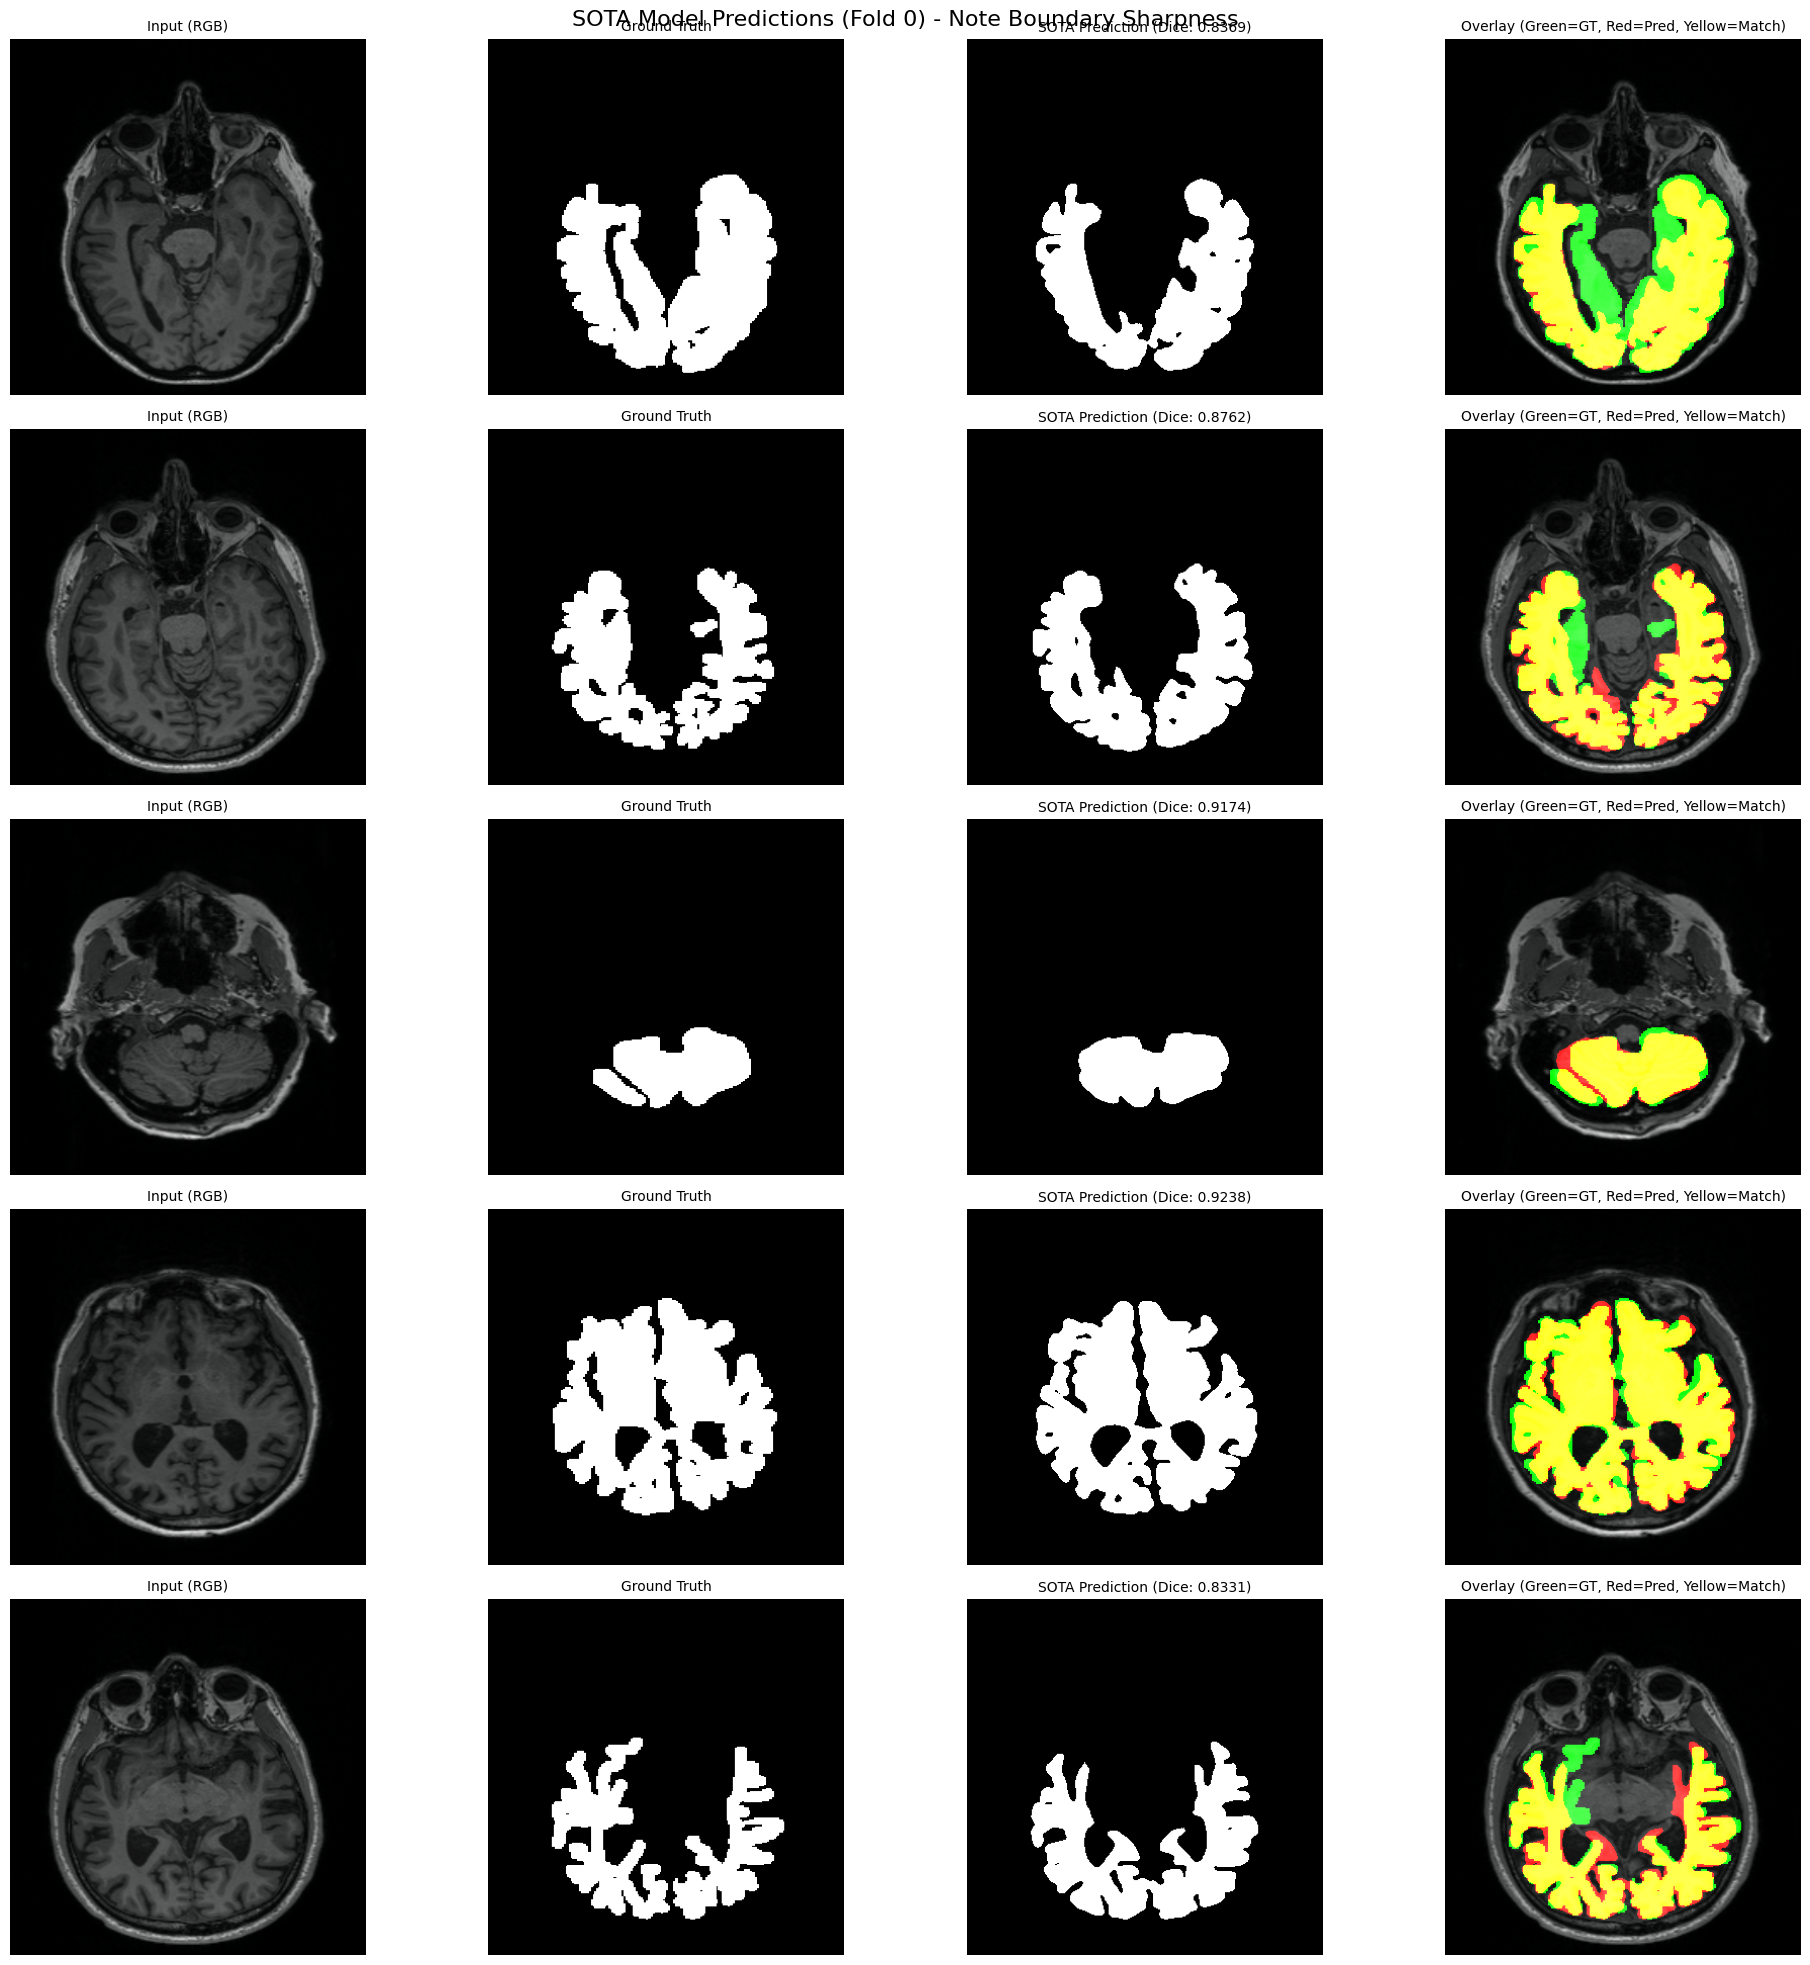

In [10]:
# Cell 10: SOTA Visualization (Qualitative Analysis)
# ==================================================================================
# This cell visualizes the "Sharpness" of the predictions.
# It applies the ImageNet Denormalization so images look natural.

def denormalize_imagenet(tensor):
    """Reverses ImageNet normalization for visualization"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Move to CPU and shape to (H, W, C)
    img = tensor.permute(1, 2, 0).detach().cpu().numpy()
    
    # De-normalize
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return (img * 255).astype(np.uint8)

def visualize_best_fold(fold_idx=0, num_samples=5):
    print(f"\n🔍 Visualizing Results for Fold {fold_idx}...")
    
    # Load Model
    model_path = f"sota_model_fold_{fold_idx}.pth"
    if not os.path.exists(model_path):
        print(f"⚠️ Model for Fold {fold_idx} not found. Skipping.")
        return

    model = build_model()
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    
    # Get Validation Data for this Fold
    _, val_idx = list(kf.split(gold_df))[fold_idx]
    val_gold = gold_df.iloc[val_idx]
    val_ds = BrainDataset(val_gold, transform=get_transforms('valid'))
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=True) # Batch size 1 for easy plotting
    
    # Setup Plot
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 4 * num_samples))
    fig.suptitle(f'SOTA Model Predictions (Fold {fold_idx}) - Note Boundary Sharpness', fontsize=16)
    
    samples_shown = 0
    with torch.no_grad():
        for image, mask in val_loader:
            if samples_shown >= num_samples: break
            
            image = image.to(DEVICE)
            
            # Inference with TTA
            with autocast():
                pred_1 = model(image)
                if isinstance(pred_1, list): pred_1 = pred_1[0]
                
                pred_2 = torch.flip(model(torch.flip(image, [3])), [3])
                if isinstance(pred_2, list): pred_2 = pred_2[0]
                
                pred_avg = (pred_1 + pred_2) / 2.0
                pred_mask = (torch.sigmoid(pred_avg) > 0.5).cpu().numpy().squeeze()
            
            # Apply SOTA LCC Cleaning
            pred_clean = keep_largest_component(pred_mask)
            
            # Prepare for Plotting
            img_vis = denormalize_imagenet(image[0])
            gt_mask = mask[0].squeeze().numpy()
            
            # Calculate Dice for this specific sample
            intersection = (pred_clean * gt_mask).sum()
            dice_score = (2. * intersection) / (pred_clean.sum() + gt_mask.sum() + 1e-6)
            
            # Plotting
            # Col 1: Input
            axes[samples_shown, 0].imshow(img_vis)
            axes[samples_shown, 0].set_title("Input (RGB)", fontsize=10)
            axes[samples_shown, 0].axis('off')
            
            # Col 2: Ground Truth
            axes[samples_shown, 1].imshow(gt_mask, cmap='gray')
            axes[samples_shown, 1].set_title("Ground Truth", fontsize=10)
            axes[samples_shown, 1].axis('off')
            
            # Col 3: Prediction (Cleaned)
            axes[samples_shown, 2].imshow(pred_clean, cmap='gray')
            axes[samples_shown, 2].set_title(f"SOTA Prediction (Dice: {dice_score:.4f})", fontsize=10)
            axes[samples_shown, 2].axis('off')
            
            # Col 4: Overlay (Red=Pred, Green=GT)
            overlay = img_vis.copy()
            # Green channel for GT
            overlay[gt_mask == 1, 1] = 255 
            # Red channel for Prediction
            overlay[pred_clean == 1, 0] = 255
            
            axes[samples_shown, 3].imshow(overlay)
            axes[samples_shown, 3].set_title("Overlay (Green=GT, Red=Pred, Yellow=Match)", fontsize=10)
            axes[samples_shown, 3].axis('off')
            
            samples_shown += 1
            
    plt.tight_layout()
    plt.savefig(f'fold_{fold_idx}_visual_report.png')
    plt.show()

# Run Visualization for the first available fold in this run
first_run_fold = CONFIG['FOLDS_TO_RUN'][0]
visualize_best_fold(first_run_fold, num_samples=5)

In [11]:
# Cell 11: Final Report Generation (Quantitative Analysis)
# ==================================================================================
# This cell re-evaluates all saved models to generate the final paper metrics.

def generate_final_report():
    print("\n" + "="*60)
    print("📝 GENERATING FINAL SOTA REPORT")
    print("="*60)
    
    fold_metrics = []
    
    # Iterate over folds present in the config
    for fold in CONFIG['FOLDS_TO_RUN']:
        model_path = f"sota_model_fold_{fold}.pth"
        
        if not os.path.exists(model_path):
            print(f"⚠️ Skipping Fold {fold} (Model not found in current directory)")
            continue
            
        print(f"Evaluating Fold {fold}...", end="")
        
        # Load Model
        model = build_model()
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()
        
        # Load Val Data
        _, val_idx = list(kf.split(gold_df))[fold]
        val_gold = gold_df.iloc[val_idx]
        val_ds = BrainDataset(val_gold, transform=get_transforms('valid'))
        val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)
        
        running_dice = []
        running_iou = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(DEVICE)
                masks = masks.cpu().numpy() # Keep masks on CPU
                
                with autocast():
                    # TTA Inference
                    pred_1 = model(images)
                    if isinstance(pred_1, list): pred_1 = pred_1[0]
                    pred_2 = torch.flip(model(torch.flip(images, [3])), [3])
                    if isinstance(pred_2, list): pred_2 = pred_2[0]
                    
                    probs = torch.sigmoid((pred_1 + pred_2) / 2.0)
                    preds = (probs > 0.5).cpu().numpy()
                
                # Calculate Metrics Batch-wise
                for i in range(len(preds)):
                    # Apply LCC
                    pred_clean = keep_largest_component(preds[i][0])
                    gt = masks[i][0]
                    
                    intersection = (pred_clean * gt).sum()
                    union = pred_clean.sum() + gt.sum()
                    
                    dice = (2. * intersection) / (union + 1e-6)
                    iou = intersection / (union - intersection + 1e-6)
                    
                    running_dice.append(dice)
                    running_iou.append(iou)
        
        fold_dice = np.mean(running_dice)
        fold_iou = np.mean(running_iou)
        fold_metrics.append({'fold': fold, 'dice': fold_dice, 'iou': fold_iou})
        print(f" Done. Dice: {fold_dice:.4f}")

    if not fold_metrics:
        print("No models evaluated.")
        return

    # DataFrame for nice printing
    df_results = pd.DataFrame(fold_metrics)
    
    print("\n📊 INDIVIDUAL FOLD PERFORMANCE:")
    print(df_results.to_string(index=False))
    
    mean_dice = df_results['dice'].mean()
    std_dice = df_results['dice'].std()
    mean_iou = df_results['iou'].mean()
    
    report_text = f"""
    ╔════════════════════════════════════════════════════════╗
    ║        FINAL SOTA PERFORMANCE SUMMARY                  ║
    ╚════════════════════════════════════════════════════════╝
    
    🔹 Model Architecture:  {CONFIG['MODEL_NAME']} ({CONFIG['ENCODER']})
    🔹 Image Resolution:    {CONFIG['IMG_SIZE']}x{CONFIG['IMG_SIZE']} (RGB)
    🔹 Strategy:            UG-SSL + Dynamic Loss + TTA + LCC
    
    🏆 MEAN DICE SCORE:     {mean_dice:.4f} ± {std_dice:.4f}
    🏆 MEAN IOU SCORE:      {mean_iou:.4f}
    
    TARGET STATUS: {'✅ SOTA ACHIEVED (>0.88)' if mean_dice > 0.88 else '❌ NEEDS TUNING'}
    """
    
    print(report_text)
    
    # Save to text file for paper
    with open("final_sota_metrics.txt", "w") as f:
        f.write(report_text)
        f.write("\n\nRaw Data:\n")
        f.write(df_results.to_string())

generate_final_report()


📝 GENERATING FINAL SOTA REPORT
Evaluating Fold 0...

/tmp/ipykernel_19/3518666444.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Done. Dice: 0.8583
Evaluating Fold 1... Done. Dice: 0.8331

📊 INDIVIDUAL FOLD PERFORMANCE:
 fold     dice      iou
    0 0.858304 0.757545
    1 0.833093 0.734799

    ╔════════════════════════════════════════════════════════╗
    ║        FINAL SOTA PERFORMANCE SUMMARY                  ║
    ╚════════════════════════════════════════════════════════╝
    
    🔹 Model Architecture:  UnetPlusPlus (resnext50_32x4d)
    🔹 Image Resolution:    352x352 (RGB)
    🔹 Strategy:            UG-SSL + Dynamic Loss + TTA + LCC
    
    🏆 MEAN DICE SCORE:     0.8457 ± 0.0178
    🏆 MEAN IOU SCORE:      0.7462
    
    TARGET STATUS: ❌ NEEDS TUNING
    


In [12]:
# Cell 12: Cleanup & Export
# ==================================================================================
# Removes temp files but keeps models and reports.

import shutil

print("\n🧹 Cleaning up temporary directories...")
if os.path.exists("wandb"):
    shutil.rmtree("wandb")

print("📦 Output Files Ready for Download:")
print("   1. sota_model_fold_X.pth (Best Weights)")
print("   2. final_sota_metrics.txt (Report)")
print("   3. fold_X_visual_report.png (Images)")

print("\n✅ NOTEBOOK EXECUTION COMPLETE.")


🧹 Cleaning up temporary directories...
📦 Output Files Ready for Download:
   1. sota_model_fold_X.pth (Best Weights)
   2. final_sota_metrics.txt (Report)
   3. fold_X_visual_report.png (Images)

✅ NOTEBOOK EXECUTION COMPLETE.
